## imports

In [81]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split as split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
pd.options.display.float_format = '{:.4f}'.format
from sklearn.metrics import  make_scorer, accuracy_score, roc_auc_score, mean_squared_error
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

## methods

In [82]:
scoring = {"accuracy": make_scorer(accuracy_score),
           "ROC_AUC": make_scorer(roc_auc_score),
           "MSE": make_scorer(mean_squared_error)}

def get_scores(model, X_test, y_test, cv=5, scoring=scoring):
    scores = cross_validate(model, X_test, y_test, cv=cv, scoring=scoring)
    print("Accuracy: %.3f" % np.mean(scores["test_accuracy"]))
    print("ROC_AUC: %.3f" % np.mean(scores["test_ROC_AUC"]))
    print("MSE: %.3f" % np.mean(scores["test_MSE"]))

def get_plot(feature_importance, X_train):
    imps = pd.Series(feature_importance, index=X_train.columns)
    imps = imps.sort_values(ascending=True)

    sns.barplot(x=imps, y=imps.index)
    plt.title("Feature Importance")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    

# ordered_neigbours = ['JARDIM DA PENHA', 'MATA DA PRAIA', 'PONTAL DE CAMBURI', 'REPÚBLICA', 'GOIABEIRAS', 'ANDORINHAS', 'CONQUISTA', 'NOVA PALESTINA', 'DA PENHA',         'TABUAZEIRO', 'BENTO FERREIRA', 'SÃO PEDRO', 'SANTA MARTHA', 'SÃO CRISTÓVÃO',         'MARUÍPE', 'GRANDE VITÓRIA', 'SÃO BENEDITO', 'ILHA DAS CAIEIRAS',         'SANTO ANDRÉ', 'SOLON BORGES', 'BONFIM', 'JARDIM CAMBURI', 'MARIA ORTIZ',         'JABOUR', 'ANTÔNIO HONÓRIO', 'RESISTÊNCIA', 'ILHA DE SANTA MARIA',         'JUCUTUQUARA', 'MONTE BELO', 'MÁRIO CYPRESTE', 'SANTO ANTÔNIO', 'BELA VISTA',         'PRAIA DO SUÁ', 'SANTA HELENA', 'ITARARÉ', 'INHANGUETÁ', 'UNIVERSITÁRIO',         'SÃO JOSÉ', 'REDENÇÃO', 'SANTA CLARA', 'CENTRO', 'PARQUE MOSCOSO',         'DO MOSCOSO', 'SANTOS DUMONT', 'CARATOÍRA', 'ARIOVALDO FAVALESSA',         'ILHA DO FRADE', 'GURIGICA', 'JOANA D´ARC', 'CONSOLAÇÃO', 'PRAIA DO CANTO',         'BOA VISTA', 'MORADA DE CAMBURI', 'SANTA LUÍZA', 'SANTA LÚCIA',         'BARRO VERMELHO', 'ESTRELINHA', 'FORTE SÃO JOÃO', 'FONTE GRANDE',         'ENSEADA DO SUÁ', 'SANTOS REIS', 'PIEDADE', 'JESUS DE NAZARETH',         'SANTA TEREZA', 'CRUZAMENTO', 'ILHA DO PRÍNCIPE', 'ROMÃO', 'COMDUSA',         'SANTA CECÍLIA', 'VILA RUBIM', 'DE LOURDES', 'DO QUADRO', 'DO CABRAL', 'HORTO',         'SEGURANÇA DO LAR', 'ILHA DO BOI', 'FRADINHOS', 'NAZARETH', 'AEROPORTO', 'ILHAS OCEÂNICAS DE TRINDADE', 'PARQUE INDUSTRIAL']
# neibours_to_int = {are: i for i, are in enumerate(ordered_neigbours)}

# def get_region(n):
#     for key, val in neibours_to_int.items():
#         if key == n:
#             return val
#     return None

## Get the data

In [83]:
#from google.colab import drive
#drive.mount('/content/drive')

In [84]:
orig = pd.read_csv("noshows.csv")
orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [85]:
orig

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,29872499824296.0000,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,558997776694438.0000,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4262962299951.0000,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,867951213174.0000,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8841186448183.0000,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110522,2572134369293.0000,5651768,F,2016-05-03T09:15:35Z,2016-06-07T00:00:00Z,56,MARIA ORTIZ,0,0,0,0,0,1,No
110523,3596266328735.0000,5650093,F,2016-05-03T07:27:33Z,2016-06-07T00:00:00Z,51,MARIA ORTIZ,0,0,0,0,0,1,No
110524,15576631729893.0000,5630692,F,2016-04-27T16:03:52Z,2016-06-07T00:00:00Z,21,MARIA ORTIZ,0,0,0,0,0,1,No
110525,92134931435557.0000,5630323,F,2016-04-27T15:09:23Z,2016-06-07T00:00:00Z,38,MARIA ORTIZ,0,0,0,0,0,1,No


In [86]:
print(max(orig['ScheduledDay']),min(orig['ScheduledDay']))


2016-06-08T20:07:23Z 2015-11-10T07:13:56Z


In [87]:
print(max(orig['AppointmentDay']),min(orig['AppointmentDay']))

2016-06-08T00:00:00Z 2016-04-29T00:00:00Z


In [88]:
orig.duplicated().any() 

False

In [89]:
orig["No-show"].value_counts()

No     88208
Yes    22319
Name: No-show, dtype: int64

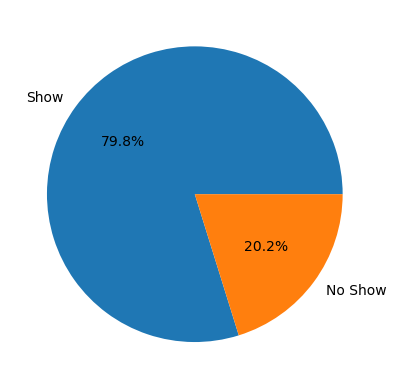

In [90]:
plt.pie(orig["No-show"].value_counts(), labels=["Show", "No Show"], autopct="%.01f%%")
plt.show()

In [91]:
orig

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,29872499824296.0000,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,558997776694438.0000,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4262962299951.0000,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,867951213174.0000,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8841186448183.0000,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110522,2572134369293.0000,5651768,F,2016-05-03T09:15:35Z,2016-06-07T00:00:00Z,56,MARIA ORTIZ,0,0,0,0,0,1,No
110523,3596266328735.0000,5650093,F,2016-05-03T07:27:33Z,2016-06-07T00:00:00Z,51,MARIA ORTIZ,0,0,0,0,0,1,No
110524,15576631729893.0000,5630692,F,2016-04-27T16:03:52Z,2016-06-07T00:00:00Z,21,MARIA ORTIZ,0,0,0,0,0,1,No
110525,92134931435557.0000,5630323,F,2016-04-27T15:09:23Z,2016-06-07T00:00:00Z,38,MARIA ORTIZ,0,0,0,0,0,1,No


In [92]:
df = orig.copy()

df["No-show"] = df["No-show"].map({"Yes":1, "No": 0})
df["Gender"] = df["Gender"].map({"M":0, "F": 1})


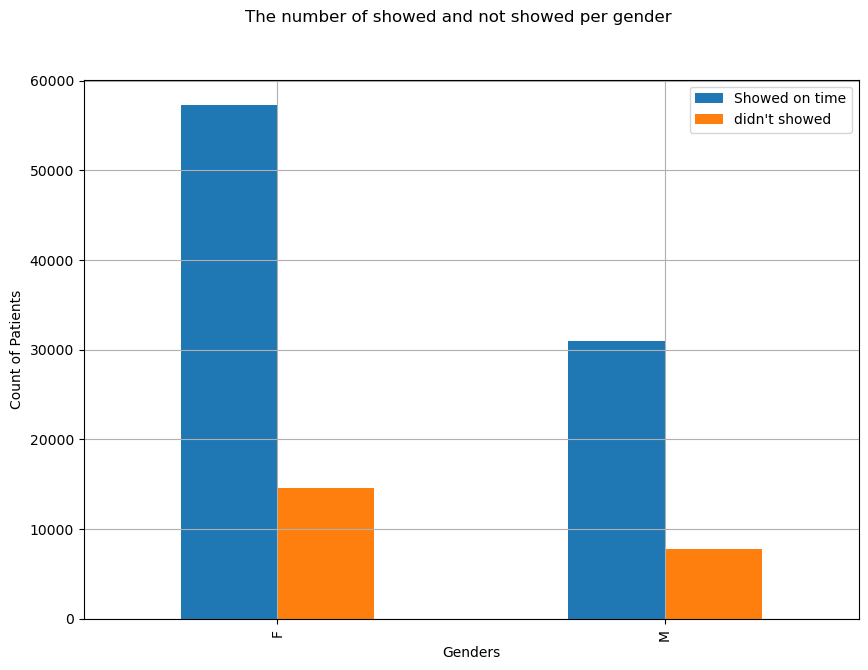

In [93]:
g_ns = orig.groupby(['Gender','No-show']).count()
g_ns['ScheduledDay'].unstack().plot(kind='bar',grid=True,figsize=(10,7))
plt.suptitle('The number of showed and not showed per gender')
plt.legend(["Showed on time",'didn\'t showed']) 
plt.xlabel('Genders')
plt.ylabel('Count of Patients');

In [116]:
def var_eff_showing(col,chart_type):
    plt.figure(figsize=[25,8])
    if chart_type == 'bar':
        df[col][df].value_counts().plot(kind='bar',alpha=.3,color='green',label='Showed')
        df[col][df].value_counts().plot(kind='bar',color='red',label='Not Showed')
        plt.title('Is this a relation between {} and showing up ?'.format(col).replace('_',' '),fontsize=25)
        plt.legend();
    elif chart_type == 'hist':
        df[col][df].hist(alpha=.3,bins = 23,color = 'green')
        df[col][df].hist(alpha=.3,bins = 23,color = 'red')
        plt.xticks(range(0,120,5))
    plt.xlabel(col.capitalize(),fontsize=20)
    plt.ylabel('Patients Number',fontsize=20)

var_eff_showing('Neighbourhood','bar')

In [94]:
df["ScheduledDay"] = df["ScheduledDay"].astype('datetime64[ns]').dt.date
df["AppointmentDay"] = df["AppointmentDay"].astype('datetime64[ns]').dt.date

In [95]:
#wrong data - scheduling after appointment day

df[df["ScheduledDay"] > df["AppointmentDay"]]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
27033,7839272661752.0000,5679978,0,2016-05-10,2016-05-09,38,RESISTÊNCIA,0,0,0,0,1,0,1
55226,7896293967868.0000,5715660,1,2016-05-18,2016-05-17,19,SANTO ANTÔNIO,0,0,0,0,1,0,1
64175,24252258389979.0000,5664962,1,2016-05-05,2016-05-04,22,CONSOLAÇÃO,0,0,0,0,0,0,1
71533,998231581612122.0000,5686628,1,2016-05-11,2016-05-05,81,SANTO ANTÔNIO,0,0,0,0,0,0,1
72362,3787481966821.0000,5655637,0,2016-05-04,2016-05-03,7,TABUAZEIRO,0,0,0,0,0,0,1


In [96]:
df = df[df["ScheduledDay"] <= df["AppointmentDay"]]

In [97]:
#clean wrong data - age < 0

df = df[df["Age"] >= 0]

In [98]:
#create new column - the interval between ScheduledDay and AppointmentDay

df["scheduled_days_before"] = (df["AppointmentDay"] - df["ScheduledDay"]).apply(lambda l: l.days)
df

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,scheduled_days_before
0,29872499824296.0000,5642903,1,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,0,0
1,558997776694438.0000,5642503,0,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,0,0
2,4262962299951.0000,5642549,1,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,0,0
3,867951213174.0000,5642828,1,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0,0
4,8841186448183.0000,5642494,1,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110522,2572134369293.0000,5651768,1,2016-05-03,2016-06-07,56,MARIA ORTIZ,0,0,0,0,0,1,0,35
110523,3596266328735.0000,5650093,1,2016-05-03,2016-06-07,51,MARIA ORTIZ,0,0,0,0,0,1,0,35
110524,15576631729893.0000,5630692,1,2016-04-27,2016-06-07,21,MARIA ORTIZ,0,0,0,0,0,1,0,41
110525,92134931435557.0000,5630323,1,2016-04-27,2016-06-07,38,MARIA ORTIZ,0,0,0,0,0,1,0,41


In [99]:
for v in [2,3,4]:
    df.Handcap.replace(v,1,inplace=True)

df.Handcap.value_counts()

0    108282
1      2239
Name: Handcap, dtype: int64

In [100]:
df["scheduled_days_before"].describe()

count   110521.0000
mean        10.1843
std         15.2552
min          0.0000
25%          0.0000
50%          4.0000
75%         15.0000
max        179.0000
Name: scheduled_days_before, dtype: float64

In [101]:
df.groupby("No-show")["Age", "SMS_received","Hipertension","Diabetes","Alcoholism","Handcap","scheduled_days_before"].mean()

,Age,SMS_received,Hipertension,Diabetes,Alcoholism,Handcap,scheduled_days_before
No-show,,,,,,,
0,37.7905,0.2913,0.2044,0.0738,0.0304,0.0208,8.7548
1,34.3179,0.4385,0.1690,0.0641,0.0303,0.0182,15.8355


<AxesSubplot:>

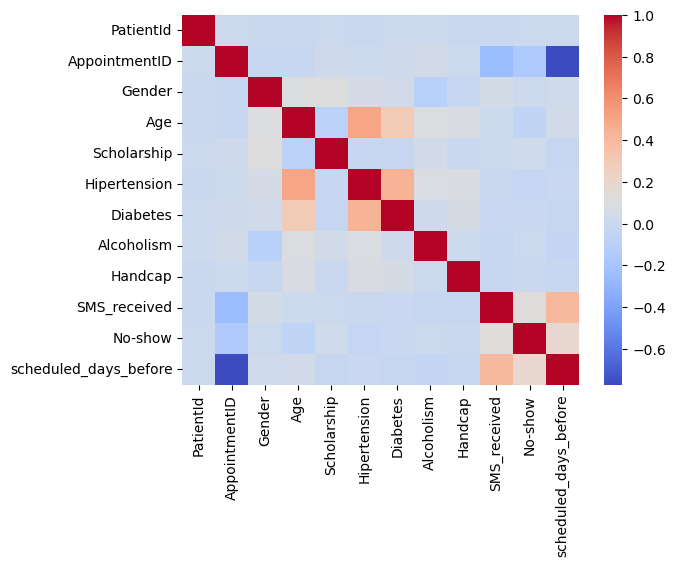

In [102]:
sns.heatmap(df.corr(), cmap="coolwarm")

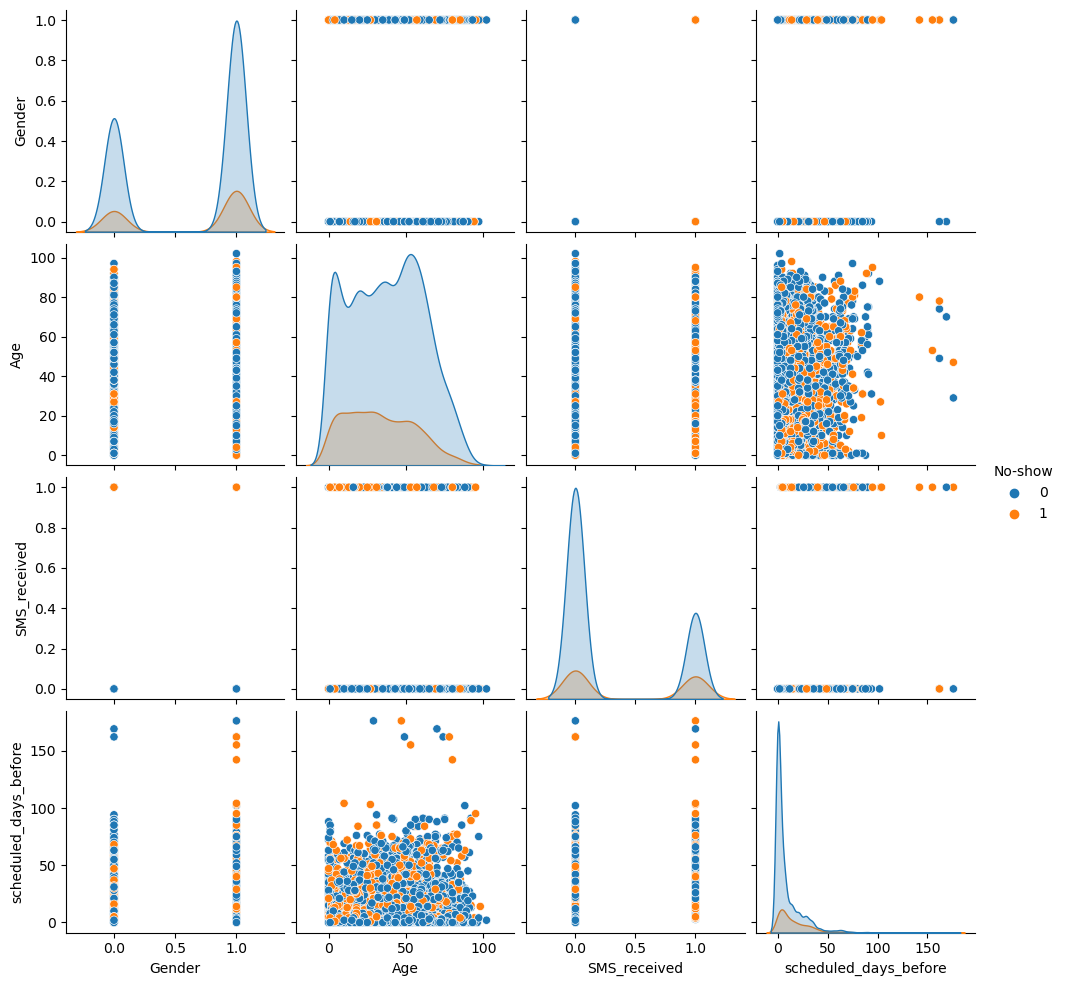

In [103]:
cols = ["Gender", "Age", "SMS_received", "scheduled_days_before"]
sns.pairplot(df.sample(10000), vars=cols, hue="No-show")
plt.show()

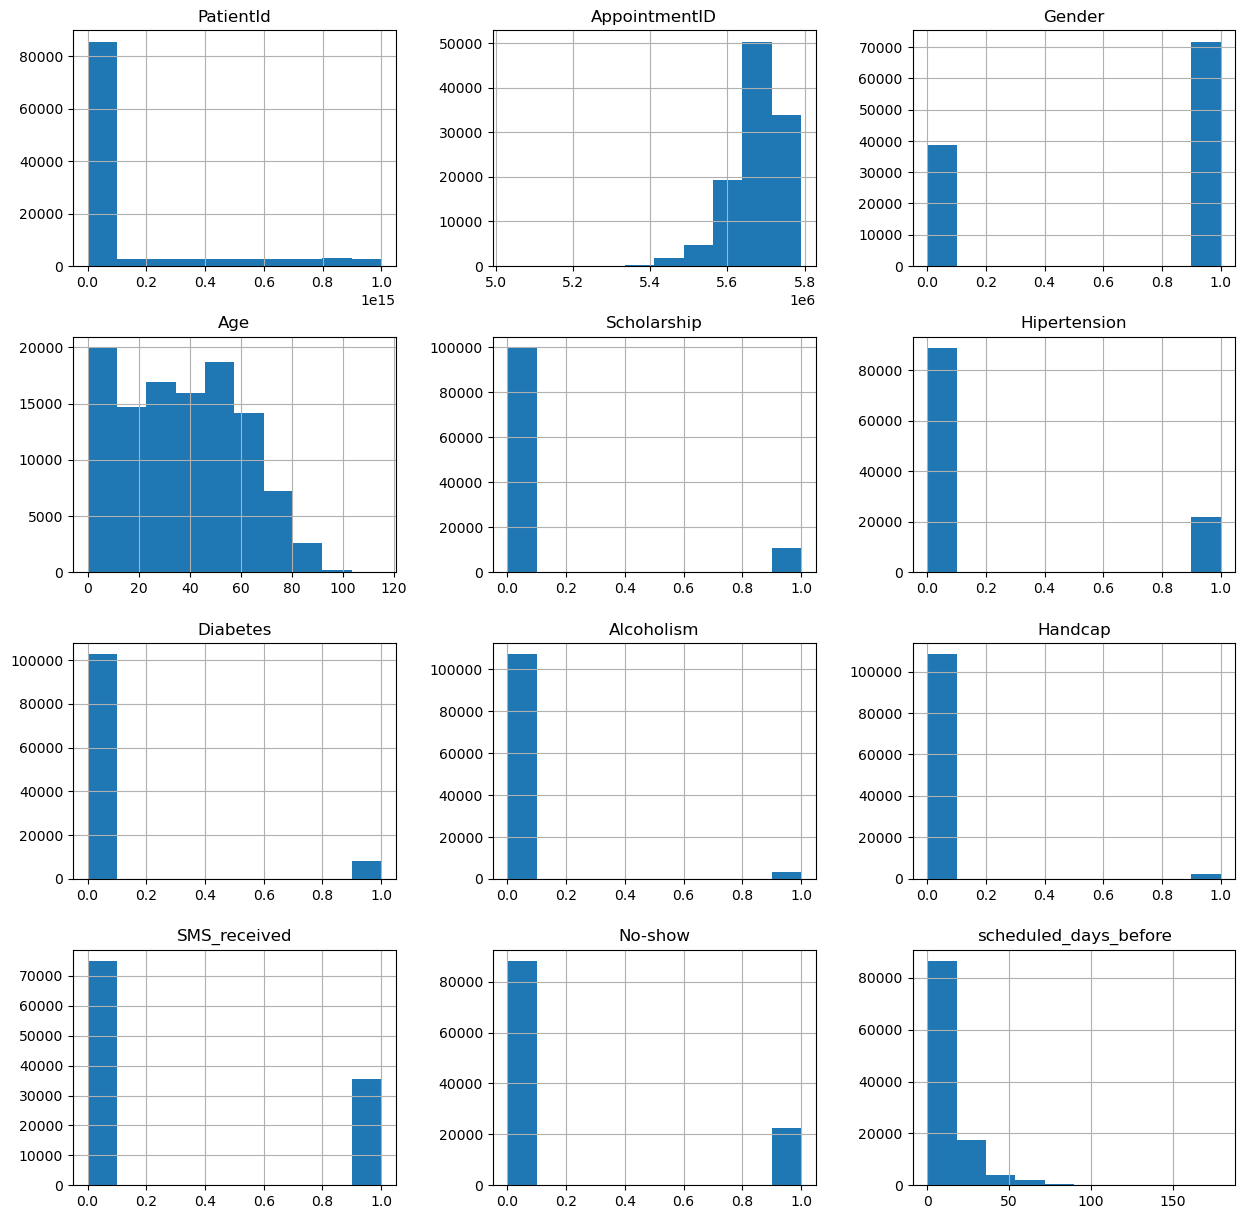

In [104]:
df.hist(figsize=(15,15));

In [105]:

# # dfg = df.groupby('Neighbourhood')['PatientId'].count().reset_index(name="count")
# # dfg[dfg['count'] > 1000]
# # df['']
# dfg = df.groupby('Neighbourhood').filter(lambda x: len(x) > 1000)
# dfg.plot(kind='bar')
# #plt.xlabel('Neighbourhood')
# #plt.ylabel('Count')
# #plt.title('Appointments by Neighbourhood')
# plt.show()
df 
#type(df["Neighbourhood_new"][0])

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,scheduled_days_before
0,29872499824296.0000,5642903,1,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,0,0
1,558997776694438.0000,5642503,0,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,0,0
2,4262962299951.0000,5642549,1,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,0,0
3,867951213174.0000,5642828,1,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0,0
4,8841186448183.0000,5642494,1,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110522,2572134369293.0000,5651768,1,2016-05-03,2016-06-07,56,MARIA ORTIZ,0,0,0,0,0,1,0,35
110523,3596266328735.0000,5650093,1,2016-05-03,2016-06-07,51,MARIA ORTIZ,0,0,0,0,0,1,0,35
110524,15576631729893.0000,5630692,1,2016-04-27,2016-06-07,21,MARIA ORTIZ,0,0,0,0,0,1,0,41
110525,92134931435557.0000,5630323,1,2016-04-27,2016-06-07,38,MARIA ORTIZ,0,0,0,0,0,1,0,41


In [106]:
drop_cols = [ "PatientId", "AppointmentID", "ScheduledDay", "AppointmentDay"]
df_final = df.drop(drop_cols, axis=1)

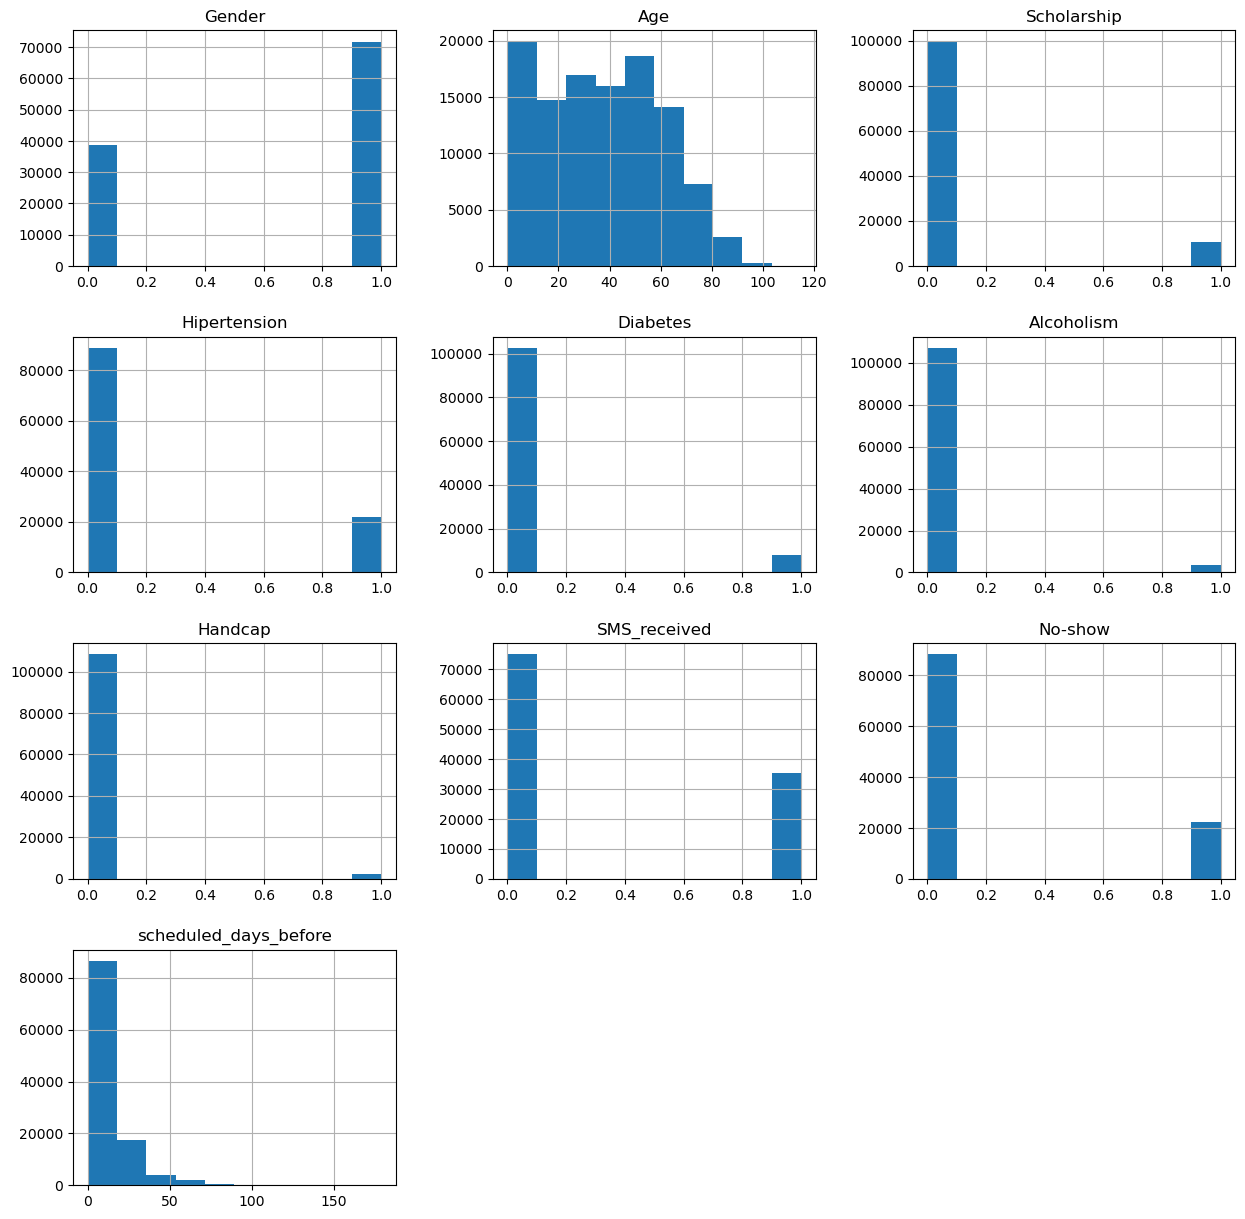

In [107]:
df_final.hist(figsize=(15,15));

(0.0, 100.0)

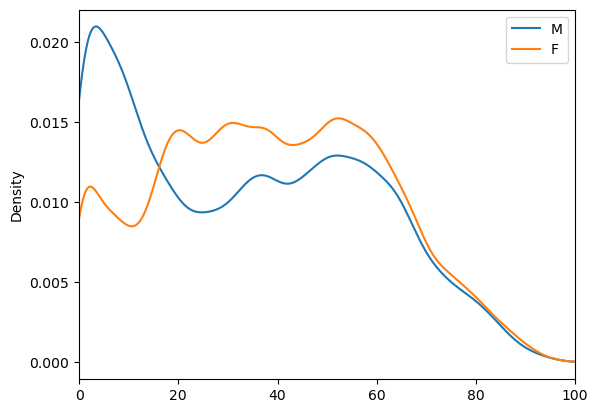

In [108]:
df.groupby('Gender').Age.plot(kind='kde' )
plt.legend(["M","F"])
plt.xlim([0, 100])

<AxesSubplot:ylabel='Density'>

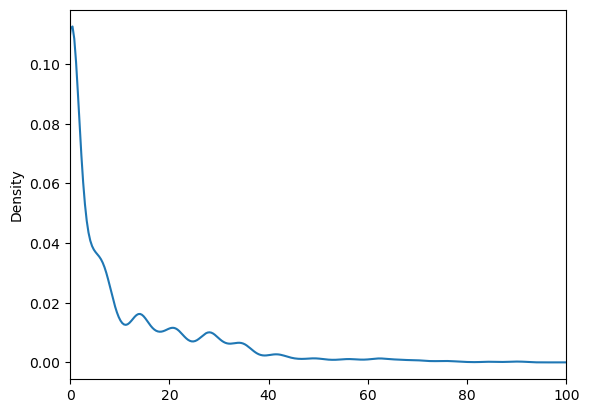

In [109]:
plt.xlim([0, 100])
df.scheduled_days_before.plot(kind='kde' )

In [110]:
df_final = df_final.drop("Neighbourhood", axis=1)
X = df_final.drop("No-show", axis=1)

y = df["No-show"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7)
print(len(X_train), len(X_test))

33156 77365


### Model

In [111]:
#type(df_final['Neighbourhood_new'][0])

Accuracy: 0.791
ROC_AUC: 0.523
MSE: 0.209


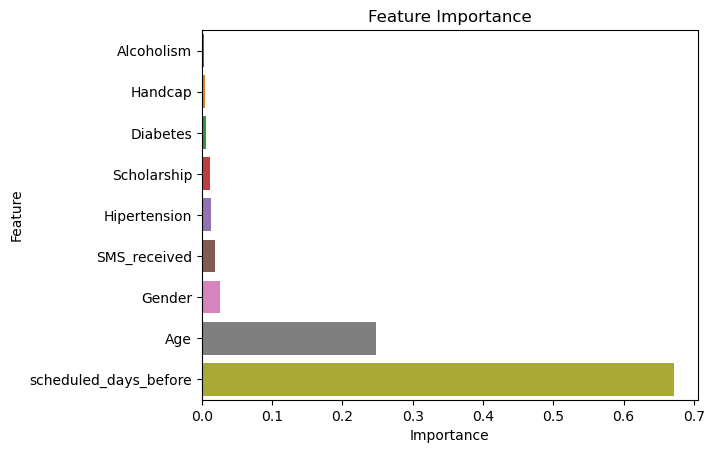

In [120]:
random_state = 124
min_samples_leaf = 25

model_1 = DecisionTreeClassifier(random_state=random_state, min_samples_leaf=min_samples_leaf)
model_1.fit(X_train, y_train)
y_pred = model_1.predict(X_test)
model_1.score(X_test, y_test)
#get_scores(model_1, X_test, y_test) cross validation
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
get_plot(model_1.feature_importances_, X_train)

In [121]:
from sklearn import metrics

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('diabetes.png')
Image(graph.create_png())


Accuracy: 0.7897111096749176


In [ ]:
print(classification_report(y_true=digits.digit,
                            y_pred=digits.digit_pred))

Accuracy: 0.796
ROC_AUC: 0.504
MSE: 0.204


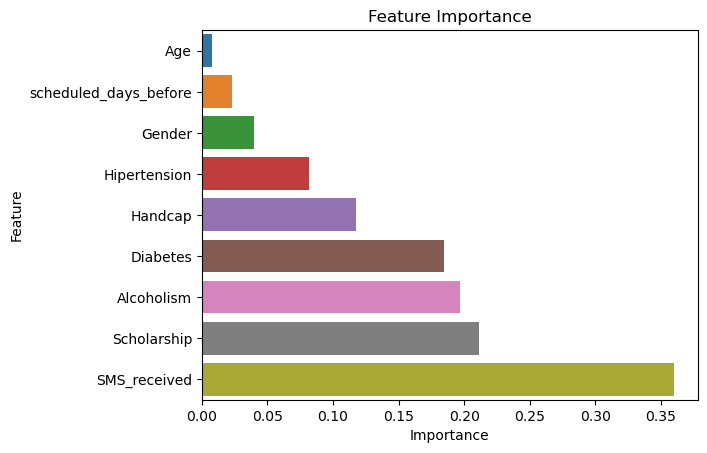

In [113]:
model_2 = LogisticRegression()
model_2.fit(X_train, y_train)
model_2.score(X_test, y_test)
coefficients = model_2.coef_
avg_importance = np.mean(np.abs(coefficients), axis=0)
get_scores(model_2, X_test, y_test)
get_plot(avg_importance, X_train)


In [114]:
model_3 = KNeighborsClassifier()
model_3.fit(X_train, y_train)
model_3.score(X_test, y_test)
get_scores(model_3, X_test, y_test)


Accuracy: 0.768
ROC_AUC: 0.544
MSE: 0.232


In [115]:
# def my_experiment_function(df1, list_of_features, my_model):
#   df_train, df_test = train_test_split(df1, random_state=1, test_size=0.2)

#   X_train, y_train = df_train[list_of_features],df_train["No-show"]
#   X_test, y_test = df_test[list_of_features],df_test["No-show"]
  
#   my_model.fit(X_train, y_train)

#   y_pred = my_model.predict(X_test)
#   score = my_model.score(X_test, y_test)
#   return score

# list_of_features = ["Gender", "Age","scheduled_days_before","SMS_received"]
# score = my_experiment_function(df, list_of_features, LogisticRegression())
# print(score)

# score = my_experiment_function(df, list_of_features, DecisionTreeClassifier())
# print(score)

# score = my_experiment_function(df, list_of_features, RandomForestClassifier())
# print(score)

# score = my_experiment_function(df, list_of_features, SVC())
# print(score)

# score = my_experiment_function(df, list_of_features, KNeighborsClassifier())
# print(score)


0.7966071024655056
0.7791902284551007
0.7742139787378421


KeyboardInterrupt: 

In [ ]:
from sklearn.model_selection import cross_val_score

cross_val_score(model, X_train, y_train, cv=5, scoring = "neg_mean_squared_error").mean()

NameError: name 'model' is not defined

In [ ]:
cross_val_score(model, X_train, y_train, cv=5, scoring = "neg_mean_squared_error")

array([-0.20525869, -0.20645781, -0.20651436, -0.20532685, -0.20543995])